# Reinforcement Learning - Parte 2: Deep RL

**Prerequisitos**: Haber completado `reinforcement_learning_clase.ipynb` (Parte 1)

## Serie Completa

| Notebook | Contenido | Estado |
|----------|-----------|--------|
| `reinforcement_learning_clase.ipynb` | Fundamentos, SARSA, Q-Learning | ✅ Completado |
| **`reinforcement_learning_dqn.ipynb`** (este) | DQN, Gymnasium, Práctica | ◄ Estás aquí |
| `reinforcement_learning_clase2.ipynb` | Stable-Baselines3, PPO, SAC | Siguiente |

---

## Índice de este Notebook

8. [Deep Q-Network (DQN)](#8-dqn) - Q-Learning + Redes Neuronales
9. [Gymnasium: Entornos de RL](#9-gymnasium) - Entornos estándar
10. [Práctica Final](#10-practica) - Implementación completa

## ¿Por qué separar?

La **Parte 1** cubre RL tabular donde:
- Estados son discretos y finitos
- Q(s,a) se almacena en una tabla/diccionario
- No se necesitan redes neuronales

La **Parte 2** (este notebook) introduce Deep RL donde:
- Estados pueden ser continuos o de alta dimensionalidad
- Q(s,a) se aproxima con una red neuronal
- Se requiere PyTorch

---

In [ ]:
# Imports necesarios para Deep RL
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict, deque

# Deep Learning
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
    print(f'PyTorch {torch.__version__} disponible')
except ImportError:
    TORCH_AVAILABLE = False
    print('PyTorch no disponible. Instalar con: pip install torch')

# Gymnasium
try:
    import gymnasium as gym
    print(f'Gymnasium {gym.__version__} disponible')
except ImportError:
    print('Gymnasium no disponible. Instalar con: pip install gymnasium')

# Configuración de visualización
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

---
<a id='8-dqn'></a>
# 8. Deep Q-Network (DQN)

DQN fue el algoritmo que revolucionó el RL moderno. En 2015, DeepMind demostró que podía aprender a jugar juegos de Atari **a nivel humano o superior**, usando solo los píxeles de la pantalla como entrada.

## El Problema de las Tablas Q

Q-Learning tabular funciona bien para problemas pequeños, pero tiene limitaciones severas:

| Problema | Estados Posibles | ¿Tabla Q viable? |
|----------|------------------|------------------|
| GridWorld 4x4 | 16 | ✅ Sí |
| Taxi (Gymnasium) | 500 | ✅ Sí |
| CartPole | ∞ (estados continuos) | ❌ No |
| Atari (píxeles) | 256^(210×160×3) ≈ 10^millions | ❌ Imposible |
| Ajedrez | ~10^47 | ❌ Imposible |
| Go | ~10^170 | ❌ Ridículamente imposible |

### El Problema de la Discretización

Una "solución" para estados continuos es discretizar:
```python
# CartPole tiene 4 variables continuas
# Si discretizamos cada una en 10 bins:
estados = 10 * 10 * 10 * 10 = 10,000  # Manejable, pero...

# Si usamos 100 bins para más precisión:
estados = 100^4 = 100,000,000  # ¡100 millones!
```

**La maldición de la dimensionalidad**: El número de estados crece exponencialmente con las dimensiones.

---

## La Solución: Aproximación de Funciones

En lugar de una tabla, usamos una **función** que aproxima Q(s, a):

```
TABLA Q (discreta)              RED NEURONAL (continua)
┌─────────────────────┐         ┌─────────────────────────────┐
│ Estado │ Q(s,a0) │..│         │      s = [x, v, θ, ω]       │
├────────┼─────────┼──┤         │            ↓                │
│ s=1    │  2.3    │..│   →→→   │     [Red Neuronal]          │
│ s=2    │  1.8    │..│         │            ↓                │
│ ...    │  ...    │..│         │ Q(s,a0), Q(s,a1), Q(s,a2)   │
└─────────────────────┘         └─────────────────────────────┘
```

### Ventajas de usar redes neuronales:

1. **Generalización**: Estados similares tienen Q-valores similares
2. **Compacto**: Millones de estados en miles de parámetros
3. **Estados continuos**: Funciona directamente, sin discretizar
4. **Representaciones ricas**: Puede aprender features automáticamente

---

## Arquitectura DQN

```
      ┌─────────────────────────────────────────────────────────┐
      │                                                         │
      │  Estado s                Capas Ocultas       Q-valores  │
      │  ┌───┐                   ┌────┐ ┌────┐       ┌───────┐  │
      │  │ x │──────┐            │    │ │    │   ┌──▶│Q(s,a₀)│  │
      │  │ v │──────┼─▶ [64] ──▶│ 64 │▶│ 64 │──┼──▶│Q(s,a₁)│  │
      │  │ θ │──────┘    ReLU    │ReLU│ │ReLU│   └──▶│Q(s,a₂)│  │
      │  │ ω │                   └────┘ └────┘       └───────┘  │
      │  └───┘                                                  │
      │  input                                        output    │
      └─────────────────────────────────────────────────────────┘
      
      Mejor acción = argmax(Q(s, a))
```

---

## El Problema: Inestabilidad del Entrenamiento

Usar redes neuronales con Q-Learning "ingenuo" no funciona bien:

### Problema 1: Correlación de Muestras
- Las transiciones consecutivas (s, a, r, s') están muy correlacionadas
- La red ve datos muy similares una y otra vez
- Esto causa sobreajuste y olvido

### Problema 2: Target Móvil
- Usamos Q(s', a') para calcular el target
- Pero ¡estamos cambiando la misma red que da esos targets!
- Es como perseguir tu propia sombra

---

## Las Innovaciones de DQN (DeepMind, 2015)

### 1. Experience Replay (Replay Buffer)

**Idea**: Guardar transiciones en una memoria y samplear aleatoriamente.

```python
# En lugar de entrenar con la última transición:
entrenar(s, a, r, s')  # ❌ Muy correlacionado

# Guardamos en un buffer y sampleamos:
buffer.guardar(s, a, r, s')
batch = buffer.sample(32)  # ✅ Muestras aleatorias, decorreladas
entrenar(batch)
```

**Beneficios**:
- Rompe la correlación temporal
- Reutiliza experiencias (eficiencia de datos)
- Suaviza la distribución de entrenamiento

### 2. Target Network (Red Objetivo)

**Idea**: Usar una copia "congelada" de la red para calcular targets.

```python
# Red Q principal (se actualiza cada paso)
Q_principal(s, a)

# Red Target (copia, se actualiza cada N pasos)
Q_target(s', a')  # Usada para calcular el target

# Cada N pasos:
Q_target.copiar_pesos_de(Q_principal)
```

**Beneficios**:
- Targets estables durante N pasos
- Reduce oscilaciones
- Permite convergencia

---

## Algoritmo DQN Completo

```
1. Inicializar red Q con pesos θ
2. Inicializar red target Q_target con pesos θ_target = θ
3. Inicializar replay buffer vacío

4. Para cada episodio:
    a. s = estado_inicial
    
    b. Mientras no termine:
        i.   Elegir a con ε-greedy sobre Q(s; θ)
        ii.  Ejecutar a, observar r, s'
        iii. Guardar (s, a, r, s', done) en buffer
        iv.  Samplear minibatch del buffer
        v.   Para cada (sᵢ, aᵢ, rᵢ, s'ᵢ, doneᵢ) en batch:
             - Si done: target = rᵢ
             - Si no:   target = rᵢ + γ max Q_target(s'ᵢ, a'; θ_target)
        vi.  Actualizar θ minimizando (Q(sᵢ,aᵢ;θ) - target)²
        vii. s = s'
    
    c. Cada C pasos: θ_target ← θ

5. Reducir ε gradualmente
```

---

## Mejoras Posteriores a DQN

| Algoritmo | Mejora | Beneficio |
|-----------|--------|-----------|
| **Double DQN** | Usa Q principal para seleccionar, Q target para evaluar | Reduce sobreestimación |
| **Dueling DQN** | Separa V(s) y A(s,a) en la arquitectura | Mejor en estados donde la acción no importa |
| **Prioritized Replay** | Samplea más las transiciones con alto TD error | Aprende más de experiencias "sorprendentes" |
| **Rainbow** | Combina todas las mejoras | Estado del arte en Atari |

In [11]:
# EJEMPLO PRÁCTICO 9: DQN Simple
# ================================
# Deep Q-Network: Q-Learning + Redes Neuronales
# Permite manejar estados continuos o de alta dimensionalidad.

# Verificar si PyTorch está disponible
try:
    import torch              # Framework de deep learning
    import torch.nn as nn     # Módulo de redes neuronales
    import torch.optim as optim  # Optimizadores (Adam, SGD, etc.)
    TORCH_AVAILABLE = True
    print("✅ PyTorch disponible")
except ImportError:
    TORCH_AVAILABLE = False
    print("⚠️ PyTorch no está instalado. Ejecuta: pip install torch")
    print("   Las celdas de DQN no funcionarán sin PyTorch.")

from collections import deque  # Cola de doble extremo (eficiente para buffers)

if TORCH_AVAILABLE:

    class ReplayBuffer:
        """
        Buffer de experiencias para Experience Replay.

        ¿Por qué Experience Replay?
        1. ROMPE CORRELACIÓN: Las experiencias consecutivas están correlacionadas
           (estado t+1 depende de t). Muestrear al azar rompe esta correlación.
        2. REUTILIZA DATOS: Cada experiencia se puede usar múltiples veces.
        3. ESTABILIDAD: El entrenamiento es más estable con batches diversos.
        """

        def __init__(self, capacidad=10000):
            """
            Args:
                capacidad: Máximo de experiencias a almacenar.
                           Cuando se llena, las más antiguas se descartan.
            """
            # deque con maxlen descarta automáticamente elementos antiguos
            self.buffer = deque(maxlen=capacidad)

        def agregar(self, estado, accion, recompensa, siguiente_estado, terminado):
            """
            Guarda una transición (s, a, r, s', done) en el buffer.

            Args:
                estado: Estado donde se tomó la acción
                accion: Acción ejecutada
                recompensa: Recompensa recibida
                siguiente_estado: Estado resultante
                terminado: Si el episodio terminó
            """
            # Guardar la tupla completa
            self.buffer.append((estado, accion, recompensa, siguiente_estado, terminado))

        def sample(self, batch_size):
            """
            Muestrea un batch aleatorio de experiencias.

            Args:
                batch_size: Número de experiencias a muestrear

            Returns:
                Tupla de arrays: (estados, acciones, recompensas, siguientes, terminados)
            """
            # random.sample elige sin repetición
            batch = random.sample(self.buffer, batch_size)

            # Desempaquetar: convertir lista de tuplas a tuplas de listas
            estados, acciones, recompensas, siguientes, terminados = zip(*batch)

            # Convertir a arrays numpy para eficiencia
            return (np.array(estados), np.array(acciones), np.array(recompensas),
                    np.array(siguientes), np.array(terminados))

        def __len__(self):
            """Devuelve el número de experiencias almacenadas."""
            return len(self.buffer)


    class DQN(nn.Module):
        """
        Red neuronal que aproxima la función Q(s, a).

        Arquitectura:
        Input (estado) → Capa 1 (64) → ReLU → Capa 2 (64) → ReLU → Output (Q-valores)

        En lugar de una tabla Q[s][a], usamos una red que:
        - Recibe: vector de estado (ej: [posición_x, posición_y])
        - Devuelve: Q-valor para cada acción [Q(s,a0), Q(s,a1), Q(s,a2), Q(s,a3)]
        """

        def __init__(self, input_size, n_acciones):
            """
            Args:
                input_size: Dimensión del vector de estado
                n_acciones: Número de acciones posibles
            """
            super(DQN, self).__init__()  # Inicializar clase padre

            # Definir la arquitectura como secuencia de capas
            self.red = nn.Sequential(
                # Capa 1: entrada → 64 neuronas
                nn.Linear(input_size, 64),
                nn.ReLU(),  # Activación no lineal

                # Capa 2: 64 → 64 neuronas
                nn.Linear(64, 64),
                nn.ReLU(),

                # Capa de salida: 64 → n_acciones
                # Cada salida es el Q-valor de una acción
                nn.Linear(64, n_acciones)
                # Sin activación: Q-valores pueden ser negativos
            )

        def forward(self, x):
            """
            Propagación hacia adelante.

            Args:
                x: Tensor de estados (batch_size, input_size)

            Returns:
                Q-valores para cada acción (batch_size, n_acciones)
            """
            return self.red(x)


    class AgenteDQN:
        """
        Agente DQN completo con Experience Replay y Target Network.

        Componentes clave:
        1. Q-Network: Red que aprende (se actualiza cada paso)
        2. Target Network: Copia de Q que se actualiza periódicamente
        3. Replay Buffer: Almacena experiencias para muestreo aleatorio
        """

        def __init__(self, input_size, n_acciones, lr=0.001, gamma=0.99, epsilon=1.0):
            """
            Args:
                input_size: Dimensión del estado
                n_acciones: Número de acciones posibles
                lr: Learning rate para el optimizador
                gamma: Factor de descuento
                epsilon: Probabilidad inicial de exploración
            """
            self.n_acciones = n_acciones
            self.gamma = gamma           # Factor de descuento
            self.epsilon = epsilon       # Exploración inicial (100%)
            self.epsilon_min = 0.01      # Exploración mínima (1%)
            self.epsilon_decay = 0.995   # Factor de decaimiento

            # RED Q (la que aprende)
            self.q_network = DQN(input_size, n_acciones)

            # RED TARGET (para estabilidad)
            # Se inicializa igual a Q y se actualiza periódicamente
            self.target_network = DQN(input_size, n_acciones)
            self.target_network.load_state_dict(self.q_network.state_dict())

            # OPTIMIZADOR: Adam es estándar para deep learning
            self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

            # FUNCIÓN DE PÉRDIDA: MSE entre Q predicho y target
            self.loss_fn = nn.MSELoss()

            # REPLAY BUFFER
            self.memory = ReplayBuffer()

        def estado_a_tensor(self, estado):
            """
            Convierte el estado (tupla) a tensor de PyTorch.

            Args:
                estado: Tupla (fila, columna)

            Returns:
                Tensor normalizado [0, 1]
            """
            # Normalizar coordenadas a rango [0, 1]
            # Esto ayuda a la red a aprender más rápido
            return torch.FloatTensor([estado[0]/3, estado[1]/3])

        def seleccionar_accion(self, estado):
            """
            Selecciona acción usando política ε-greedy.

            Args:
                estado: Estado actual

            Returns:
                Índice de la acción seleccionada
            """
            # Explorar con probabilidad epsilon
            if random.random() < self.epsilon:
                return random.randint(0, self.n_acciones - 1)

            # Explotar: usar la red para elegir la mejor acción
            with torch.no_grad():  # No calcular gradientes (solo inferencia)
                estado_tensor = self.estado_a_tensor(estado).unsqueeze(0)
                q_valores = self.q_network(estado_tensor)
                return q_valores.argmax().item()  # Índice del máximo

        def recordar(self, estado, accion, recompensa, siguiente_estado, terminado):
            """Guarda experiencia en el replay buffer."""
            self.memory.agregar(estado, accion, recompensa, siguiente_estado, terminado)

        def entrenar(self, batch_size=32):
            """
            Entrena la red Q con un batch del replay buffer.

            Este es el núcleo del algoritmo DQN.

            Args:
                batch_size: Número de experiencias para entrenar

            Returns:
                loss: Pérdida del entrenamiento (para monitoreo)
            """
            # No entrenar si no hay suficientes experiencias
            if len(self.memory) < batch_size:
                return 0

            # PASO 1: Muestrear batch aleatorio del buffer
            estados, acciones, recompensas, siguientes, terminados = self.memory.sample(batch_size)

            # PASO 2: Convertir a tensores de PyTorch
            estados_t = torch.FloatTensor([[s[0]/3, s[1]/3] for s in estados])
            acciones_t = torch.LongTensor(acciones)
            recompensas_t = torch.FloatTensor(recompensas)
            siguientes_t = torch.FloatTensor([[s[0]/3, s[1]/3] for s in siguientes])
            terminados_t = torch.FloatTensor(terminados)

            # PASO 3: Calcular Q-valores actuales para las acciones tomadas
            # q_network(estados) devuelve Q para todas las acciones
            # gather selecciona solo las Q de las acciones que se tomaron
            q_actuales = self.q_network(estados_t).gather(1, acciones_t.unsqueeze(1))

            # PASO 4: Calcular targets usando la TARGET network
            # Esta es la clave de DQN: usar red separada para estabilidad
            with torch.no_grad():
                # Máximo Q del siguiente estado (según target network)
                q_siguientes = self.target_network(siguientes_t).max(1)[0]
                # Si terminó, no hay futuro
                q_siguientes = q_siguientes * (1 - terminados_t)
                # Target = r + γ * max Q(s', a')
                targets = recompensas_t + self.gamma * q_siguientes

            # PASO 5: Calcular pérdida (diferencia entre predicción y target)
            loss = self.loss_fn(q_actuales.squeeze(), targets)

            # PASO 6: Backpropagation
            self.optimizer.zero_grad()  # Limpiar gradientes anteriores
            loss.backward()             # Calcular gradientes
            self.optimizer.step()       # Actualizar pesos

            return loss.item()

        def actualizar_target(self):
            """
            Copia los pesos de q_network a target_network.

            Se hace periódicamente (cada N episodios) para estabilidad.
            """
            self.target_network.load_state_dict(self.q_network.state_dict())

        def decaer_epsilon(self):
            """Reduce epsilon gradualmente (explorar menos con el tiempo)."""
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


    print("\n✅ Clases DQN definidas correctamente")
    print("   - ReplayBuffer: Almacena experiencias")
    print("   - DQN: Red neuronal para Q-valores")
    print("   - AgenteDQN: Agente completo con entrenamiento")

✅ PyTorch disponible

📋 Componentes DQN:
   - ReplayBuffer: Almacena experiencias pasadas
   - DQN: Red neuronal que aproxima Q(s,a)
   - AgenteDQN: Integra todo para aprender


ENTRENAMIENTO DQN


Episodio   0 | Recompensa: -100.0 | Promedio: -100.00 | ε: 0.995


Episodio  50 | Recompensa:   -8.0 | Promedio: -22.16 | ε: 0.774


Episodio 100 | Recompensa:   -2.0 | Promedio:  -8.68 | ε: 0.603


Episodio 150 | Recompensa:    4.0 | Promedio:  -1.20 | ε: 0.469


Episodio 200 | Recompensa:    4.0 | Promedio:   1.40 | ε: 0.365


Episodio 250 | Recompensa:    4.0 | Promedio:   2.24 | ε: 0.284


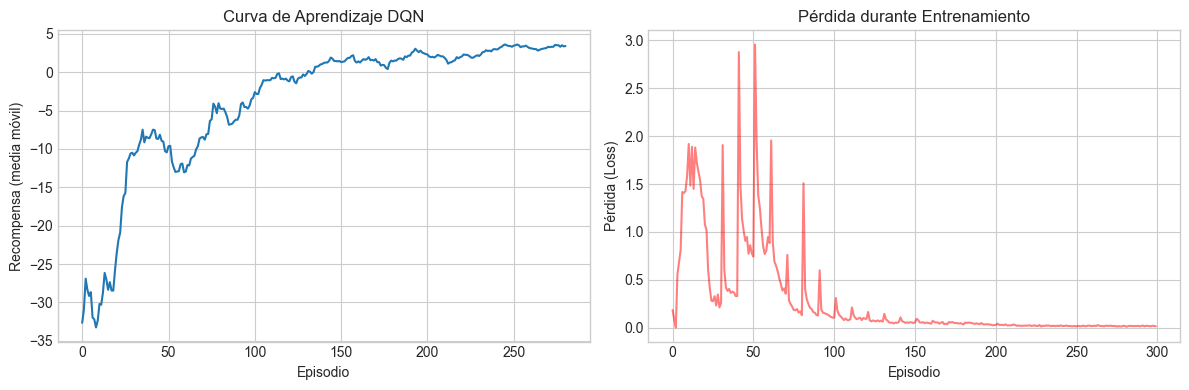


📊 DQN entrenado exitosamente
Recompensa promedio final: 3.28


In [12]:
# EJEMPLO PRÁCTICO 10: Entrenar DQN en GridWorld

if not TORCH_AVAILABLE:
    print("⚠️ PyTorch no disponible. Salta esta celda.")
else:
    def entrenar_dqn(env, n_episodios=300):
        """Entrena un agente DQN"""
        agente = AgenteDQN(input_size=2, n_acciones=4)
        
        recompensas_historial = []
        perdidas_historial = []
        
        for episodio in range(n_episodios):
            estado = env.reset()
            recompensa_total = 0
            perdida_total = 0
            pasos = 0
            
            for _ in range(100):
                accion = agente.seleccionar_accion(estado)
                siguiente, recompensa, terminado = env.step(accion)
                
                agente.recordar(estado, accion, recompensa, siguiente, terminado)
                perdida = agente.entrenar(batch_size=32)
                
                recompensa_total += recompensa
                perdida_total += perdida
                pasos += 1
                estado = siguiente
                
                if terminado:
                    break
            
            # Actualizar target network cada 10 episodios
            if episodio % 10 == 0:
                agente.actualizar_target()
            
            agente.decay_epsilon()
            
            recompensas_historial.append(recompensa_total)
            perdidas_historial.append(perdida_total / max(pasos, 1))
            
            if episodio % 50 == 0:
                promedio = np.mean(recompensas_historial[-50:]) if len(recompensas_historial) >= 50 else np.mean(recompensas_historial)
                print(f"Episodio {episodio:3d} | Recompensa: {recompensa_total:6.1f} | "
                      f"Promedio: {promedio:6.2f} | ε: {agente.epsilon:.3f}")
        
        return agente, recompensas_historial, perdidas_historial


    # Entrenar
    print("=" * 60)
    print("ENTRENAMIENTO DQN")
    print("=" * 60)

    env = GridWorld()
    agente_dqn, recompensas_dqn, perdidas_dqn = entrenar_dqn(env, n_episodios=300)

    # Visualizar
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    window = 20
    recompensas_suav = np.convolve(recompensas_dqn, np.ones(window)/window, mode='valid')

    axes[0].plot(recompensas_suav)
    axes[0].set_xlabel('Episodio')
    axes[0].set_ylabel('Recompensa (media móvil)')
    axes[0].set_title('Curva de Aprendizaje DQN')

    axes[1].plot(perdidas_dqn, color='red', alpha=0.5)
    axes[1].set_xlabel('Episodio')
    axes[1].set_ylabel('Pérdida (Loss)')
    axes[1].set_title('Pérdida durante Entrenamiento')

    plt.tight_layout()
    plt.show()

    print(f"\n📊 DQN entrenado exitosamente")
    print(f"Recompensa promedio final: {np.mean(recompensas_dqn[-50:]):.2f}")

---
<a id='9-gymnasium'></a>
# 9. Gymnasium: Entornos de RL

## ¿Qué es Gymnasium?

**Gymnasium** (antes OpenAI Gym) es la librería estándar para crear y usar entornos de RL. Piensa en ella como el "framework de testing" del RL.

### ¿Por qué necesitamos Gymnasium?

1. **Estandarización**: Todos los entornos tienen la misma interfaz
2. **Reproducibilidad**: Fácil comparar algoritmos en los mismos entornos
3. **Benchmarks**: Entornos clásicos para medir el progreso
4. **Comunidad**: Miles de entornos disponibles

### Entornos Populares

| Categoría | Entornos | Descripción |
|-----------|----------|-------------|
| **Control Clásico** | CartPole, MountainCar, Pendulum, Acrobot | Problemas de física simples, ideales para empezar |
| **Box2D** | LunarLander, BipedalWalker, CarRacing | Física 2D más realista |
| **Atari** | Breakout, Pong, Space Invaders, 50+ juegos | Videojuegos clásicos |
| **MuJoCo** | Ant, Humanoid, HalfCheetah | Robótica 3D de alta fidelidad |
| **Toy Text** | FrozenLake, Taxi, Blackjack | Entornos de texto para debugging |

---

## Gymnasium y la Teoría de RL

Cada componente de Gymnasium implementa un concepto teórico del framework de RL:

```
TEORÍA (MDP)                         GYMNASIUM (Código)
============                         ==================

    Entorno E                    ←→  env = gym.make("...")
        ↓                                    ↓
    Espacio de Estados S         ←→  env.observation_space
    Espacio de Acciones A        ←→  env.action_space
        ↓                                    ↓
    Estado inicial s₀            ←→  obs, info = env.reset()
        ↓                                    ↓
    ┌─────────────────┐              ┌─────────────────────────┐
    │ Paso temporal t │              │ obs, r, term, trunc, _  │
    │                 │         ←→   │   = env.step(action)    │
    │ P(s'|s,a): s'   │              │                         │
    │ R(s,a): r       │              │ obs = s', r = reward    │
    └─────────────────┘              └─────────────────────────┘
        ↓                                    ↓
    Estado terminal              ←→  terminated = True
    Horizonte T (límite)         ←→  truncated = True
```

### Tabla de Correspondencias

| Concepto Teórico | Símbolo | Gymnasium | Ejemplo |
|------------------|---------|-----------|---------|
| Entorno | E | `env` | `gym.make("CartPole-v1")` |
| Espacio de estados | S | `env.observation_space` | `Box(4,)` = 4 valores continuos |
| Espacio de acciones | A | `env.action_space` | `Discrete(2)` = 2 acciones |
| Estado actual | s | `observation` | `[0.02, 0.5, -0.01, -0.3]` |
| Acción | a | `action` | `0` o `1` |
| Función de transición | P(s'\|s,a) | `env.step()` → `obs` | Física del entorno |
| Función de recompensa | R(s,a) | `env.step()` → `reward` | `+1` por cada paso |
| Estado terminal | s ∈ S_terminal | `terminated` | Poste cayó |
| Horizonte finito | T | `truncated` | 500 pasos máximo |
| Estado inicial | s₀ | `env.reset()` | Posición inicial |
| Factor descuento | γ | En tu agente | `gamma = 0.99` |
| Política | π(a\|s) | Tu agente | `agent.select_action(obs)` |

---

## La API de Gymnasium

### Ciclo Básico

```python
import gymnasium as gym

# 1. Crear el entorno
env = gym.make("CartPole-v1")

# 2. Reiniciar (obtener estado inicial)
observation, info = env.reset()

# 3. Bucle de interacción
for _ in range(1000):
    action = env.action_space.sample()  # Tu agente elegiría aquí
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

# 4. Cerrar el entorno
env.close()
```

### Componentes de la API

| Método/Atributo | Descripción | Retorna |
|-----------------|-------------|---------|
| `env.reset()` | Reinicia el entorno | `(observation, info)` |
| `env.step(action)` | Ejecuta una acción | `(obs, reward, terminated, truncated, info)` |
| `env.observation_space` | Describe el espacio de observaciones | `Box`, `Discrete`, etc. |
| `env.action_space` | Describe el espacio de acciones | `Box`, `Discrete`, etc. |
| `env.close()` | Libera recursos | None |

### Terminated vs Truncated

- **terminated**: El episodio terminó por razones del entorno (ej: el poste cayó, llegaste a la meta)
- **truncated**: El episodio terminó por límite de tiempo (ej: máximo 500 pasos)

```python
done = terminated or truncated  # Para compatibilidad con código antiguo
```

---

## Espacios (Spaces)

Los espacios definen qué observaciones y acciones son válidas.

### Tipos de Espacios

| Tipo | Descripción | Ejemplo |
|------|-------------|---------|
| `Discrete(n)` | Enteros de 0 a n-1 | Acciones: izq/der = `Discrete(2)` |
| `Box(low, high, shape)` | Arreglo de floats | Observación 4D: `Box(-inf, inf, (4,))` |
| `MultiBinary(n)` | Array de 0s y 1s | Botones presionados: `MultiBinary(8)` |
| `MultiDiscrete([n1, n2])` | Múltiples discretos | Joystick: `MultiDiscrete([3, 3])` |
| `Dict({...})` | Diccionario de espacios | Observación compleja |
| `Tuple((s1, s2))` | Tupla de espacios | Múltiples sensores |

### Métodos Útiles de Espacios

```python
# Generar una muestra aleatoria válida
action = env.action_space.sample()

# Verificar si un valor está en el espacio
is_valid = env.observation_space.contains(obs)

# Obtener límites (para Box)
low = env.observation_space.low
high = env.observation_space.high
```

---

## VectorEnv: Entornos Paralelos

Para entrenar más rápido, puedes ejecutar **múltiples entornos en paralelo**. Esto es esencial para algoritmos como PPO y A2C.

### ¿Por qué usar VectorEnv?

| Sin VectorEnv | Con VectorEnv |
|---------------|---------------|
| 1 entorno, 1 CPU | N entornos, N CPUs |
| Recolecta 1 experiencia por step | Recolecta N experiencias por step |
| Entrenamiento lento | Entrenamiento N veces más rápido |

### Tipos de VectorEnv

```python
from gymnasium.vector import SyncVectorEnv, AsyncVectorEnv

# SyncVectorEnv: Todos los entornos avanzan juntos (más simple)
envs = SyncVectorEnv([
    lambda: gym.make("CartPole-v1"),
    lambda: gym.make("CartPole-v1"),
    lambda: gym.make("CartPole-v1"),
    lambda: gym.make("CartPole-v1"),
])  # 4 entornos en paralelo

# AsyncVectorEnv: Cada entorno avanza independiente (más eficiente)
envs = AsyncVectorEnv([
    lambda: gym.make("CartPole-v1") for _ in range(4)
])
```

### Uso de VectorEnv

```python
# Reset devuelve array de observaciones (una por entorno)
observations, infos = envs.reset()
print(observations.shape)  # (4, 4) = 4 entornos × 4 features

# Step recibe array de acciones (una por entorno)
actions = np.array([0, 1, 0, 1])  # Acción para cada entorno
observations, rewards, terminateds, truncateds, infos = envs.step(actions)

# Los entornos que terminan se resetean automáticamente
```

---

## Crear un Entorno Custom

Puedes crear tus propios entornos siguiendo la interfaz de Gymnasium.

### Estructura Básica

```python
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class MiEntornoCustom(gym.Env):
    """Plantilla para crear un entorno personalizado."""

    metadata = {"render_modes": ["human", "rgb_array"]}

    def __init__(self, render_mode=None):
        super().__init__()

        # DEFINIR ESPACIO DE ACCIONES
        self.action_space = spaces.Discrete(4)  # 4 acciones

        # DEFINIR ESPACIO DE OBSERVACIONES
        self.observation_space = spaces.Box(
            low=np.array([0, 0]),
            high=np.array([10, 10]),
            dtype=np.float32
        )

        self.state = None
        self.render_mode = render_mode

    def reset(self, seed=None, options=None):
        """Reinicia el entorno al estado inicial."""
        super().reset(seed=seed)

        # Inicializar estado
        self.state = self.np_random.uniform(low=0, high=10, size=(2,)).astype(np.float32)

        return self.state, {}

    def step(self, action):
        """Ejecuta una acción en el entorno."""
        # Aplicar acción
        moves = {0: [0, 1], 1: [1, 0], 2: [0, -1], 3: [-1, 0]}
        self.state = np.clip(self.state + moves[action], 0, 10).astype(np.float32)

        # Calcular recompensa
        goal = np.array([10, 10])
        distance = np.linalg.norm(self.state - goal)
        reward = -distance

        # Verificar si terminó
        terminated = distance < 0.5
        if terminated:
            reward += 100

        return self.state, reward, terminated, False, {}

    def render(self):
        if self.render_mode == "human":
            print(f"Posición: {self.state}")
```

### Registrar el Entorno

```python
from gymnasium.envs.registration import register

register(
    id="MiEntorno-v1",
    entry_point="mi_modulo:MiEntornoCustom",
    max_episode_steps=200,
)

# Ahora puedes usar: gym.make("MiEntorno-v1")
```

### Checklist para Entornos Custom

| Requisito | Descripción |
|-----------|-------------|
| ✅ `action_space` | Definido en `__init__` |
| ✅ `observation_space` | Definido en `__init__` |
| ✅ `reset()` → `(obs, info)` | Devuelve estado inicial válido |
| ✅ `step(action)` → 5 valores | `(obs, reward, terminated, truncated, info)` |

---

## Wrappers: Modificando Entornos

Los wrappers modifican el comportamiento sin cambiar el código del entorno.

### Wrappers Comunes

```python
from gymnasium.wrappers import TimeLimit, RecordVideo, NormalizeObservation, ClipReward

env = gym.make("CartPole-v1")
env = TimeLimit(env, max_episode_steps=200)
env = RecordVideo(env, "videos/", episode_trigger=lambda x: x % 100 == 0)
```

### Wrappers y Teoría RL

| Wrapper | Modifica | Concepto Teórico |
|---------|----------|------------------|
| `TimeLimit` | truncated | Horizonte T |
| `ClipReward` | reward | Función R(s,a) |
| `NormalizeObservation` | observation | Espacio S |
| `FrameStack` | observation | Estado como historial |

---

## Renderizado

```python
# Render en tiempo real (abre ventana)
env = gym.make("CartPole-v1", render_mode="human")

# Render como imagen RGB (para grabar)
env = gym.make("CartPole-v1", render_mode="rgb_array")
frame = env.render()

# Sin renderizado (más rápido para entrenar)
env = gym.make("CartPole-v1")
```

---

## Reproducibilidad (Seeding)

```python
# Semilla al resetear (recomendado)
observation, info = env.reset(seed=42)

# Para VectorEnv
observations, infos = envs.reset(seed=[42, 43, 44, 45])
```

In [13]:
# EJEMPLO PRÁCTICO 11: Explorando Gymnasium

# Instalar gymnasium si no está disponible
try:
    import gymnasium as gym
except ModuleNotFoundError:
    print("Instalando gymnasium...")
    !pip install gymnasium -q
    import gymnasium as gym

print("=" * 60)
print("EXPLORANDO GYMNASIUM")
print("=" * 60)

# Crear entorno CartPole
env = gym.make("CartPole-v1")

print("\n📦 Entorno: CartPole-v1")
print("-" * 40)
print(f"Espacio de observación: {env.observation_space}")
print(f"  - Tipo: {type(env.observation_space).__name__}")
print(f"  - Forma: {env.observation_space.shape}")
print(f"  - Límites: {env.observation_space.low} a {env.observation_space.high}")

print(f"\nEspacio de acciones: {env.action_space}")
print(f"  - Número de acciones: {env.action_space.n}")
print(f"  - Acciones: 0 = empujar izquierda, 1 = empujar derecha")

# Reset
observacion, info = env.reset(seed=42)
print(f"\n🔄 Después de reset():")
print(f"  Observación: {observacion}")
print(f"  Info: {info}")

# Un paso
accion = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(accion)

print(f"\n⚡ Después de step({accion}):")
print(f"  Nueva observación: {obs}")
print(f"  Recompensa: {reward}")
print(f"  Terminado: {terminated}")
print(f"  Truncado: {truncated}")

env.close()

# Significado de la observación en CartPole
print("\n" + "=" * 60)
print("SIGNIFICADO DE LA OBSERVACIÓN EN CARTPOLE")
print("=" * 60)
print("""
La observación es un vector de 4 valores:
  [0] Posición del carro     (-4.8 a 4.8)
  [1] Velocidad del carro    (-∞ a ∞)
  [2] Ángulo del poste       (-0.42 rad a 0.42 rad)
  [3] Velocidad angular      (-∞ a ∞)

Objetivo: Mantener el poste en equilibrio
Recompensa: +1 por cada paso que el poste sigue en pie
Termina cuando:
  - El poste se inclina más de 12°
  - El carro sale del límite
  - Se alcanzan 500 pasos (éxito)
""")

EXPLORANDO GYMNASIUM

📦 Entorno: CartPole-v1
----------------------------------------
Espacio de observación: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  - Tipo: Box
  - Forma: (4,)
  - Límites: [-4.8               -inf -0.41887903        -inf] a [4.8               inf 0.41887903        inf]

Espacio de acciones: Discrete(2)
  - Número de acciones: 2
  - Acciones: 0 = empujar izquierda, 1 = empujar derecha

🔄 Después de reset():
  Observación: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
  Info: {}

⚡ Después de step(0):
  Nueva observación: [ 0.02727336 -0.20172954  0.03625453  0.32351476]
  Recompensa: 1.0
  Terminado: False
  Truncado: False

SIGNIFICADO DE LA OBSERVACIÓN EN CARTPOLE

La observación es un vector de 4 valores:
  [0] Posición del carro     (-4.8 a 4.8)
  [1] Velocidad del carro    (-∞ a ∞)
  [2] Ángulo del poste       (-0.42 rad a 0.42 rad)
  [3] Velocidad angular      (-∞ a ∞)

Objetivo: 

In [14]:
# EJEMPLO PRÁCTICO 12: Probando diferentes entornos

# Asegurarse de que gym está importado
try:
    gym
except NameError:
    import gymnasium as gym

# Entornos que siempre están disponibles (sin dependencias extra)
entornos_basicos = [
    ("CartPole-v1", "Equilibrar un poste sobre un carro"),
    ("MountainCar-v0", "Subir un coche a la cima de una montaña"),
    ("Acrobot-v1", "Balancear un brazo robótico hacia arriba"),
]

# Entornos que requieren dependencias adicionales
entornos_extra = [
    ("LunarLander-v3", "Aterrizar una nave espacial (requiere: pip install gymnasium[box2d])"),
]

print("=" * 70)
print("ENTORNOS POPULARES DE GYMNASIUM")
print("=" * 70)

for nombre, descripcion in entornos_basicos:
    try:
        env = gym.make(nombre)
        print(f"\n📦 {nombre}")
        print(f"   {descripcion}")
        print(f"   Observaciones: {env.observation_space}")
        print(f"   Acciones: {env.action_space}")
        
        # Probar un episodio aleatorio
        obs, _ = env.reset()
        recompensa_total = 0
        pasos = 0
        
        for _ in range(200):
            accion = env.action_space.sample()
            obs, recompensa, terminado, truncado, _ = env.step(accion)
            recompensa_total += recompensa
            pasos += 1
            if terminado or truncado:
                break
        
        print(f"   Prueba aleatoria: {pasos} pasos, recompensa = {recompensa_total:.1f}")
        env.close()
        
    except Exception as e:
        print(f"\n⚠️ {nombre}: Error - {e}")

# Intentar entornos extra
print("\n" + "-" * 70)
print("ENTORNOS ADICIONALES (requieren instalación extra)")
print("-" * 70)

for nombre, descripcion in entornos_extra:
    try:
        env = gym.make(nombre)
        print(f"\n✅ {nombre} - Disponible")
        print(f"   {descripcion}")
        print(f"   Observaciones: {env.observation_space}")
        print(f"   Acciones: {env.action_space}")
        env.close()
    except Exception as e:
        print(f"\n❌ {nombre} - No instalado")
        print(f"   {descripcion}")

print("\n" + "=" * 70)
print("💡 Para instalar entornos adicionales:")
print("   pip install gymnasium[box2d]    # LunarLander, BipedalWalker")
print("   pip install gymnasium[atari]    # Juegos Atari")
print("=" * 70)

ENTORNOS POPULARES DE GYMNASIUM

📦 CartPole-v1
   Equilibrar un poste sobre un carro
   Observaciones: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
   Acciones: Discrete(2)
   Prueba aleatoria: 14 pasos, recompensa = 14.0

📦 MountainCar-v0
   Subir un coche a la cima de una montaña
   Observaciones: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
   Acciones: Discrete(3)
   Prueba aleatoria: 200 pasos, recompensa = -200.0

📦 Acrobot-v1
   Balancear un brazo robótico hacia arriba
   Observaciones: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
   Acciones: Discrete(3)
   Prueba aleatoria: 200 pasos, recompensa = -200.0

----------------------------------------------------------------------
ENTORNOS ADICIONALES (requieren instalación extra)
----------------------------------------------------------------------

❌ Lu

---
<a id='10-practica'></a>
# 10. Práctica Final

## Objetivo

**Entrega un Jupyter Notebook donde cargues un environment de Gymnasium y entrenes un bot que aprenda a resolver la tarea.**

---

## Pasos Recomendados

### Paso 1: Elegir un Entorno

| Dificultad | Entorno | Descripción | Algoritmo Recomendado |
|------------|---------|-------------|----------------------|
| ⭐ Fácil | `CartPole-v1` | Equilibrar un poste | Q-Learning (discretizado) o DQN |
| ⭐ Fácil | `FrozenLake-v1` | Navegar en hielo | Q-Learning tabular |
| ⭐⭐ Media | `MountainCar-v0` | Subir una colina | DQN (recompensa sparse) |
| ⭐⭐ Media | `LunarLander-v3` | Aterrizar nave | DQN o PPO (requiere box2d) |
| ⭐⭐⭐ Difícil | `Acrobot-v1` | Balancear robot | DQN con buen diseño |

### Paso 2: Analizar el Entorno

Antes de implementar nada, entiende tu entorno:

```python
import gymnasium as gym

env = gym.make("TU_ENTORNO")
print(f"Observaciones: {env.observation_space}")
print(f"Acciones: {env.action_space}")

# Ejecuta varios episodios aleatorios para entender el problema
obs, _ = env.reset()
for _ in range(100):
    action = env.action_space.sample()
    obs, reward, term, trunc, info = env.step(action)
    print(f"Obs: {obs}, Reward: {reward}")
    if term or trunc:
        break
```

**Preguntas a responder:**
- ¿Cuántas dimensiones tiene la observación?
- ¿Cuántas acciones hay?
- ¿Cuándo termina un episodio?
- ¿Cómo es la estructura de recompensas?

### Paso 3: Diseñar el Agente

Elige tu enfoque:

| Enfoque | Cuándo usarlo | Complejidad |
|---------|---------------|-------------|
| **Q-Learning Tabular** | Estados discretos (FrozenLake, Taxi) | Baja |
| **Q-Learning + Discretización** | Estados continuos simples (CartPole) | Media |
| **DQN** | Estados continuos, más dimensiones | Alta |
| **Stable-Baselines3** | Cualquier entorno, sin implementar desde cero | Baja (usar librería) |

### Paso 4: Entrenar y Visualizar

Tu notebook debe incluir:

1. **Curva de aprendizaje**: Recompensa vs episodio
2. **Métricas**: Recompensa promedio, desviación estándar
3. **Evaluación final**: Ejecutar el agente entrenado sin exploración

### Paso 5: Analizar Resultados

Responde en tu notebook:
- ¿El agente aprendió? ¿Cómo lo sabes?
- ¿Qué hiperparámetros probaste?
- ¿Qué cambiarías para mejorarlo?

---

## Requisitos del Entregable

| Requisito | Puntos | Descripción |
|-----------|--------|-------------|
| Código funcional | 30% | El notebook ejecuta sin errores y entrena un agente |
| Curvas de aprendizaje | 20% | Gráfica que muestra mejora del agente |
| Evaluación | 20% | Demostrar el agente final funcionando |
| Documentación | 20% | Explicar decisiones, hiperparámetros, resultados |
| Creatividad | 10% | Entorno diferente, mejoras al algoritmo, análisis extra |

---

## Opción A: Implementación Desde Cero

Si quieres entender los algoritmos a fondo, implementa tu propio agente.

### Plantilla Q-Learning con Discretización (CartPole)

In [15]:
# ============================================================
# PRÁCTICA FINAL: REINFORCEMENT LEARNING
# ============================================================
# Nombre: [TU NOMBRE]
# Fecha: [FECHA]
# Entorno elegido: [NOMBRE DEL ENTORNO]
# ============================================================

# Imports necesarios (gymnasium ya debería estar instalado)
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import random

# Opcional: Para DQN (descomenta si lo usas)
# import torch
# import torch.nn as nn
# import torch.optim as optim

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [16]:
# PASO 1: Cargar y explorar el entorno
# ============================================================

# TODO: Elige tu entorno
env = gym.make("CartPole-v1")  # Cambia esto si quieres otro entorno

print("=" * 50)
print("ANÁLISIS DEL ENTORNO")
print("=" * 50)

# TODO: Analiza el espacio de estados y acciones
print(f"Espacio de observación: {env.observation_space}")
print(f"Espacio de acciones: {env.action_space}")

# TODO: Describe qué significa cada observación y acción

ANÁLISIS DEL ENTORNO
Espacio de observación: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Espacio de acciones: Discrete(2)


In [17]:
# PASO 2: Implementar el agente
# ============================================================

# TODO: Implementa tu agente aquí
# Puedes usar Q-Learning (con discretización), DQN, o tu propio algoritmo

class MiAgente:
    def __init__(self, env):
        # TODO: Inicializa tu agente
        pass
    
    def seleccionar_accion(self, estado):
        # TODO: Implementa la selección de acción
        pass
    
    def aprender(self, estado, accion, recompensa, siguiente_estado, terminado):
        # TODO: Implementa el algoritmo de aprendizaje
        pass

In [18]:
# PASO 3: Entrenar el agente
# ============================================================

def entrenar(env, agente, n_episodios=500):
    """Función de entrenamiento"""
    recompensas = []
    
    for episodio in range(n_episodios):
        estado, _ = env.reset()
        recompensa_total = 0
        terminado = False
        truncado = False
        
        while not (terminado or truncado):
            # TODO: Completa el bucle de entrenamiento
            accion = agente.seleccionar_accion(estado)
            siguiente, recompensa, terminado, truncado, _ = env.step(accion)
            
            agente.aprender(estado, accion, recompensa, siguiente, terminado or truncado)
            
            estado = siguiente
            recompensa_total += recompensa
        
        recompensas.append(recompensa_total)
        
        if episodio % 100 == 0:
            print(f"Episodio {episodio}: Recompensa = {recompensa_total:.1f}")
    
    return recompensas

# TODO: Entrena tu agente
# agente = MiAgente(env)
# recompensas = entrenar(env, agente)

In [19]:
# PASO 4: Visualizar resultados
# ============================================================

# TODO: Grafica las curvas de aprendizaje

# plt.figure(figsize=(10, 5))
# plt.plot(recompensas)
# plt.xlabel('Episodio')
# plt.ylabel('Recompensa')
# plt.title('Curva de Aprendizaje')
# plt.show()

In [20]:
# PASO 5: Evaluar el agente entrenado
# ============================================================

def evaluar(env, agente, n_episodios=10):
    """Evalúa el agente sin exploración"""
    recompensas = []
    
    for _ in range(n_episodios):
        estado, _ = env.reset()
        recompensa_total = 0
        terminado = False
        truncado = False
        
        while not (terminado or truncado):
            # TODO: Evalúa sin exploración (greedy)
            accion = agente.seleccionar_accion(estado)  # Sin epsilon
            estado, recompensa, terminado, truncado, _ = env.step(accion)
            recompensa_total += recompensa
        
        recompensas.append(recompensa_total)
    
    print(f"Evaluación: {np.mean(recompensas):.1f} ± {np.std(recompensas):.1f}")
    return recompensas

# TODO: Evalúa tu agente
# evaluar(env, agente)

---

## Opción B: Usando Stable-Baselines3 (Recomendado para principiantes)

Si prefieres enfocarte en entender RL sin implementar algoritmos desde cero, usa Stable-Baselines3.

### Instalación
```bash
pip install stable-baselines3
```

### Ejemplo Completo con PPO

```python
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import gymnasium as gym

# 1. Crear entorno
env = gym.make("CartPole-v1")

# 2. Crear agente
model = PPO(
    "MlpPolicy",        # Política con red neuronal
    env,
    learning_rate=0.0003,
    gamma=0.99,
    verbose=1           # Muestra progreso
)

# 3. Entrenar
model.learn(total_timesteps=50_000)

# 4. Evaluar
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Recompensa: {mean_reward:.2f} ± {std_reward:.2f}")

# 5. Guardar modelo
model.save("cartpole_ppo")

# 6. Demostración visual
env = gym.make("CartPole-v1", render_mode="human")
obs, _ = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, _ = env.reset()
env.close()
```

---

## Criterios de Evaluación

| Criterio | Puntos |
|----------|--------|
| Código funcional que entrena un agente | 30% |
| Curvas de aprendizaje que muestran mejora | 20% |
| Evaluación del agente entrenado | 20% |
| Documentación y explicaciones | 20% |
| Creatividad (entorno diferente, mejoras al algoritmo) | 10% |

---

## Errores Comunes y Cómo Evitarlos

| Error | Causa | Solución |
|-------|-------|----------|
| El agente no mejora | Learning rate muy alto/bajo | Probar α = 0.001, 0.01, 0.1 |
| Recompensa oscila mucho | Epsilon muy alto al final | Reducir ε gradualmente hasta 0.01 |
| Se queda en óptimo local | Poca exploración inicial | Empezar con ε = 1.0 |
| Olvida lo aprendido | Buffer muy pequeño (DQN) | Aumentar tamaño del buffer |
| Entrenamiento muy lento | Renderizado activo | Quitar `render_mode="human"` |

---

## Tips Finales

1. **Empieza simple**: CartPole-v1 es perfecto para empezar
2. **Loggea todo**: Guarda métricas para analizar después
3. **Usa semillas**: `env.reset(seed=42)` para reproducibilidad
4. **Experimenta**: Cambia hiperparámetros y observa el efecto
5. **No te rindas**: El RL es difícil, los agentes a veces tardan en aprender

---

# Recursos Adicionales

## Libros (de más accesible a más avanzado)

| Libro | Autor | Nivel | Enlace |
|-------|-------|-------|--------|
| **Grokking Deep RL** | Miguel Morales | Principiante | Con código Python paso a paso |
| **RL: An Introduction** | Sutton & Barto | Intermedio | [Gratis online](http://incompleteideas.net/book/the-book-2nd.html) - EL libro clásico |
| **Deep RL Hands-On** | Maxim Lapan | Avanzado | Implementaciones prácticas con PyTorch |

## Cursos Online (Gratuitos)

| Curso | Plataforma | Descripción |
|-------|------------|-------------|
| **Deep RL Course** | Hugging Face | El mejor curso práctico actual, con certificado |
| **RL Specialization** | Coursera (Alberta) | Curso académico riguroso |
| **Spinning Up** | OpenAI | Documentación + código de referencia |
| **RL Course** | DeepMind x UCL | Lecturas en YouTube por expertos de DeepMind |

## Librerías Principales

| Librería | Uso | Instalación |
|----------|-----|-------------|
| **Gymnasium** | Entornos estándar | `pip install gymnasium` |
| **Stable-Baselines3** | Algoritmos listos para usar | `pip install stable-baselines3` |
| **RLlib** | RL escalable y distribuido | `pip install ray[rllib]` |
| **CleanRL** | Implementaciones simples y claras | `pip install cleanrl` |
| **TorchRL** | RL con PyTorch (oficial) | `pip install torchrl` |

## Papers Fundamentales

| Año | Paper | Contribución |
|-----|-------|--------------|
| 2013 | Playing Atari with Deep RL | Primer DQN exitoso |
| 2015 | Human-level control through deep RL | DQN en Nature, Experience Replay + Target Network |
| 2016 | Asynchronous Methods for Deep RL | A3C: Entrenamiento paralelo |
| 2017 | Proximal Policy Optimization | PPO: Algoritmo robusto y simple |
| 2018 | Soft Actor-Critic | SAC: Estado del arte en control continuo |

## Entornos Interesantes para Explorar

| Entorno | Instalación | Descripción |
|---------|-------------|-------------|
| Atari | `pip install gymnasium[atari,accept-rom-license]` | Videojuegos clásicos |
| Box2D | `pip install gymnasium[box2d]` | LunarLander, CarRacing |
| MuJoCo | `pip install gymnasium[mujoco]` | Robótica 3D (ahora gratuito) |
| Minigrid | `pip install minigrid` | Laberintos 2D personalizables |
| Highway | `pip install highway-env` | Conducción autónoma |
| PettingZoo | `pip install pettingzoo` | Multi-agente |

---

**¡Buena suerte con tu práctica!**

Recuerda: El RL requiere **paciencia**. Es normal que los agentes tarden en aprender o que los primeros intentos no funcionen. ¡Experimenta, ajusta hiperparámetros, y disfruta del proceso!